In [1]:
suppressPackageStartupMessages({
  library(structToolbox)
  library(ggplot2)
  library(gridExtra)
  library(cowplot)
  library(dplyr)
})

In [2]:
data <- read.csv("C:/Users/HP/Desktop/Machine learning biociencias/Glioma.csv")

In [3]:
clinical_cols <- c("years_to_birth", "gender", "histological_type", "race", 
                   "ethnicity", "radiation_therapy", "Grade", "Mutation.Count", 
                   "Percent.aneuploidy", "IDH.status", "outcome")

In [4]:
# Identificar columnas de proteínas (las que terminan en "_p")
# Identificar columnas de proteínas (las que terminan en "_p")
protein_cols <- names(data)[grepl("_p$", names(data))]

# Crear metadatos de muestras
SM <- data[, clinical_cols, drop = FALSE]
# Convertir variables categóricas a factores
SM$gender <- factor(SM$gender)
SM$histological_type <- factor(SM$histological_type)
SM$race <- factor(SM$race)
SM$ethnicity <- factor(SM$ethnicity)
SM$radiation_therapy <- factor(SM$radiation_therapy)
SM$Grade <- factor(SM$Grade)
SM$IDH.status <- factor(SM$IDH.status)
SM$outcome <- factor(SM$outcome)

# Matriz de datos proteómicos
X <- data[, protein_cols, drop = FALSE]

In [5]:
# Metadatos de variables (proteínas)
VM <- data.frame(
  protein_id = protein_cols,
  protein_name = gsub("_p$", "", protein_cols),  # Quitar el sufijo "_p"
  is_phosphorylated = TRUE,
  row.names = protein_cols
)

# Crear objeto DatasetExperiment
DE <- DatasetExperiment(
  data = X,
  sample_meta = SM,
  variable_meta = VM,
  description = 'Análisis proteómico de datos fosforilación',
  name = 'Proteomics phosphorylation analysis'
)

print(DE)

A "DatasetExperiment" object
----------------------------
name:          Proteomics phosphorylation analysis
description:   Análisis proteómico de datos fosforilación
data:          306 rows x 174 columns
sample_meta:   306 rows x 11 columns
variable_meta: 174 rows x 3 columns


In [7]:
# PASO 2: CONTROL DE CALIDAD (ADAPTADO PARA PROTEÓMICA)
# Como tus datos ya están normalizados, omitimos algunos filtros
# pero podemos aplicar filtros básicos

# Filtrar proteínas con muchos valores faltantes
# Necesitamos especificar factor_name para el filtro
M <- mv_feature_filter(threshold = 20, method = 'across', factor_name = 'outcome')
M <- model_apply(M, DE)
filtered <- predicted(M)

print(paste("Proteínas después del filtrado:", ncol(filtered$data)))

[1] "Proteínas después del filtrado: 174"


In [8]:
# PASO 3: ANÁLISIS EXPLORATORIO CON PCA
# Como los datos ya están normalizados, podemos hacer PCA directamente
# o aplicar solo centrado y escalado

# Preparar secuencia de modelos para PCA
M_pca <- mean_centre() +  # Centrar datos
  autoscale() +     # Escalar a varianza unitaria
  knn_impute(neighbours = 3) +  # Imputar valores faltantes
  PCA(number_components = 10)

# Aplicar secuencia
M_pca <- model_apply(M_pca, filtered)

# Gráficos de PCA
# Scores plot coloreado por outcome
C1 <- pca_scores_plot(factor_name = 'outcome')
g1 <- chart_plot(C1, M_pca[4])

# Scores plot coloreado por tipo histológico
C2 <- pca_scores_plot(factor_name = 'histological_type')
g2 <- chart_plot(C2, M_pca[4])

# Scores plot coloreado por grado
C3 <- pca_scores_plot(factor_name = 'Grade')
g3 <- chart_plot(C3, M_pca[4])

# Loadings plot
C4 <- pca_loadings_plot()
g4 <- chart_plot(C4, M_pca[4])


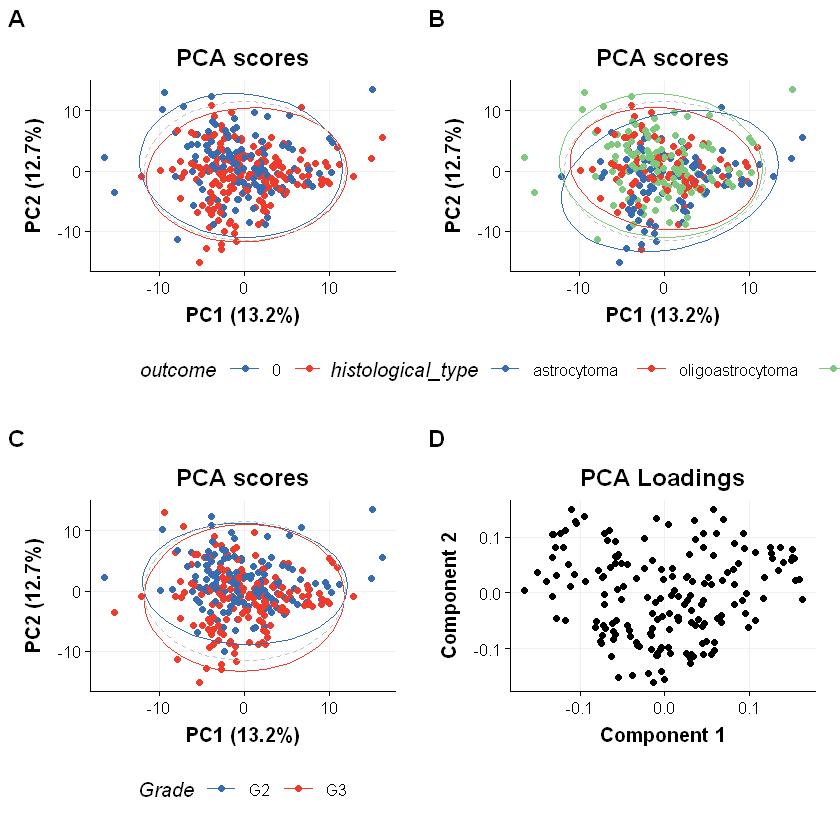

In [9]:
# Combinar gráficos
plot_grid(g1, g2, g3, g4, align = 'hv', nrow = 2, axis = 'tblr',
          labels = c('A', 'B', 'C', 'D'))


In [10]:
# PASO 4: ESTADÍSTICA UNIVARIADA
# Comparación entre outcomes (asumiendo que es binario: 0 vs 1)

# Preparar modelo para t-test
TT <- ttest(alpha = 0.05, mtc = 'fdr', factor_names = 'outcome')

# Aplicar modelo
TT <- model_apply(TT, filtered)

# El objeto ttest es S4 con slots, necesitamos usar slotNames() para ver los slots disponibles
print("Slots disponibles en el objeto ttest:")
print(slotNames(TT))

[1] "Slots disponibles en el objeto ttest:"
 [1] "alpha"          "mtc"            "factor_names"   "paired"        
 [5] "paired_factor"  "equal_variance" "conf_level"     "t_statistic"   
 [9] "p_value"        "dof"            "significant"    "conf_int"      
[13] "estimates"      "predicted"      "seq_in"         "seq_fcn"       
[17] "name"           "description"    "type"           "libraries"     
[21] "citations"      "ontology"       ".params"        ".outputs"      


In [11]:
# Los resultados usualmente están en slots específicos del objeto modelo aplicado
# Intentar acceder a los resultados de diferentes maneras
if(length(TT) > 0) {
  # Si es una lista de resultados
  print("Estructura de los resultados:")
  print(str(TT))
} else {
  # Intentar acceder directamente a los slots de resultados comunes
  print("Intentando acceder a slots de resultados...")
}

# Método alternativo: usar funciones específicas de structToolbox para extraer resultados
# Muchos objetos de structToolbox tienen métodos específicos para extraer datos
try({
  # Intentar extraer usando método genérico
  if(exists("predicted")) {
    results <- predicted(TT)
    print("Resultados extraídos usando predicted():")
    print(head(results))
  }
}, silent = TRUE)

# Método más simple: crear comparación manual si los métodos anteriores fallan
print("=== MÉTODO ALTERNATIVO ===")
print("Si los métodos automáticos fallan, podemos hacer el análisis manualmente:")

[1] "Estructura de los resultados:"
Formal class 'ttest' [package "structToolbox"] with 24 slots
  ..@ alpha         :Formal class 'entity' [package "struct"] with 10 slots
  .. .. ..@ value      : num 0.05
  .. .. ..@ max_length : num Inf
  .. .. ..@ name       : chr "Confidence level"
  .. .. ..@ description: chr "The p-value cutoff for determining significance."
  .. .. ..@ type       : chr "numeric"
  .. .. ..@ libraries  : chr(0) 
  .. .. ..@ citations  :List of 1
  .. .. .. ..$ :List of 1
  .. .. .. .. ..$ :Classes 'citation', 'bibentry'  hidden list of 1
  .. .. .. .. .. ..$ :List of 8
  .. .. .. .. .. .. ..$ title  : chr "struct: an R/Bioconductor-based framework for standardized metabolomics data analysis and beyond"
  .. .. .. .. .. .. ..$ author :List of 3
  .. .. .. .. .. .. .. ..$ :Class 'person'  hidden list of 1
  .. .. .. .. .. .. .. .. ..$ :List of 5
  .. .. .. .. .. .. .. .. .. ..$ given  : chr [1:2] "Gavin" "Rhys"
  .. .. .. .. .. .. .. .. .. ..$ family : chr "Lloyd"

In [13]:
# Extraer los datos filtrados para análisis manual
data_for_analysis <- filtered$data
sample_meta <- filtered$sample_meta

# Realizar t-test manual para cada proteína
manual_results <- data.frame(
  protein = colnames(data_for_analysis),
  p_value = numeric(ncol(data_for_analysis)),
  t_statistic = numeric(ncol(data_for_analysis)),
  stringsAsFactors = FALSE
)

# Realizar t-test para cada proteína (solo si outcome tiene exactamente 2 niveles)
if(length(unique(sample_meta$outcome)) == 2) {
  for(i in 1:ncol(data_for_analysis)) {
    protein_data <- data_for_analysis[, i]
    groups <- sample_meta$outcome
    
    # Remover NAs
    complete_cases <- complete.cases(protein_data, groups)
    if(sum(complete_cases) > 3) {  # Al menos 4 observaciones
      test_result <- t.test(protein_data[complete_cases] ~ groups[complete_cases])
      manual_results$p_value[i] <- test_result$p.value
      manual_results$t_statistic[i] <- test_result$statistic
    } else {
      manual_results$p_value[i] <- NA
      manual_results$t_statistic[i] <- NA
    }
  }
# Aplicar corrección FDR
  manual_results$p_adjusted <- p.adjust(manual_results$p_value, method = "fdr")
  manual_results$significant <- ifelse(manual_results$p_adjusted < 0.05, 1, 0)
  
  # Mostrar proteínas significativas
  significant_proteins <- manual_results[manual_results$significant == 1 & !is.na(manual_results$significant), ]
  print(paste("Proteínas significativas (método manual):", nrow(significant_proteins)))
  if(nrow(significant_proteins) > 0) {
    print("Top proteínas significativas:")
    print(head(significant_proteins[order(significant_proteins$p_adjusted), ]))
  }
} else {
  print("La variable 'outcome' no tiene exactamente 2 niveles para t-test")
  print("Niveles únicos encontrados:")
  print(unique(sample_meta$outcome))
}

[1] "Proteínas significativas (método manual): 47"
[1] "Top proteínas significativas:"
        protein      p_value t_statistic   p_adjusted significant
139       Syk_p 1.288008e-10   -6.724882 2.241133e-08           1
15         AR_p 3.357540e-09   -6.118436 1.947373e-07           1
149 YAP_pS127_p 2.606283e-09   -6.175567 1.947373e-07           1
148       YAP_p 2.292305e-07   -5.295353 9.971528e-06           1
10       ACC1_p 1.504180e-06    4.935016 5.234548e-05           1
154     c.Kit_p 1.851407e-06    4.875148 5.369080e-05           1


In [14]:
# PASO 5: ANÁLISIS MULTIVARIADO - DIVISIÓN DE DATOS
# División estratificada para mantener proporción de outcomes
M_split <- stratified_split(p_train = 0.75, factor_name = 'outcome')
M_split <- model_apply(M_split, filtered)

train_data <- M_split$training
test_data <- M_split$testing

print(paste("Muestras de entrenamiento:", nrow(train_data$data)))
print(paste("Muestras de prueba:", nrow(test_data$data)))

# PASO 6: OPTIMIZACIÓN DEL NÚMERO DE COMPONENTES PLS
# Preparar datos de entrenamiento
M_prep <- mean_centre() +
  autoscale() + 
  knn_impute(neighbours = 3, by = 'samples')

M_prep <- model_apply(M_prep, train_data)
train_prepared <- predicted(M_prep)

[1] "Muestras de entrenamiento: 229"
[1] "Muestras de prueba: 77"


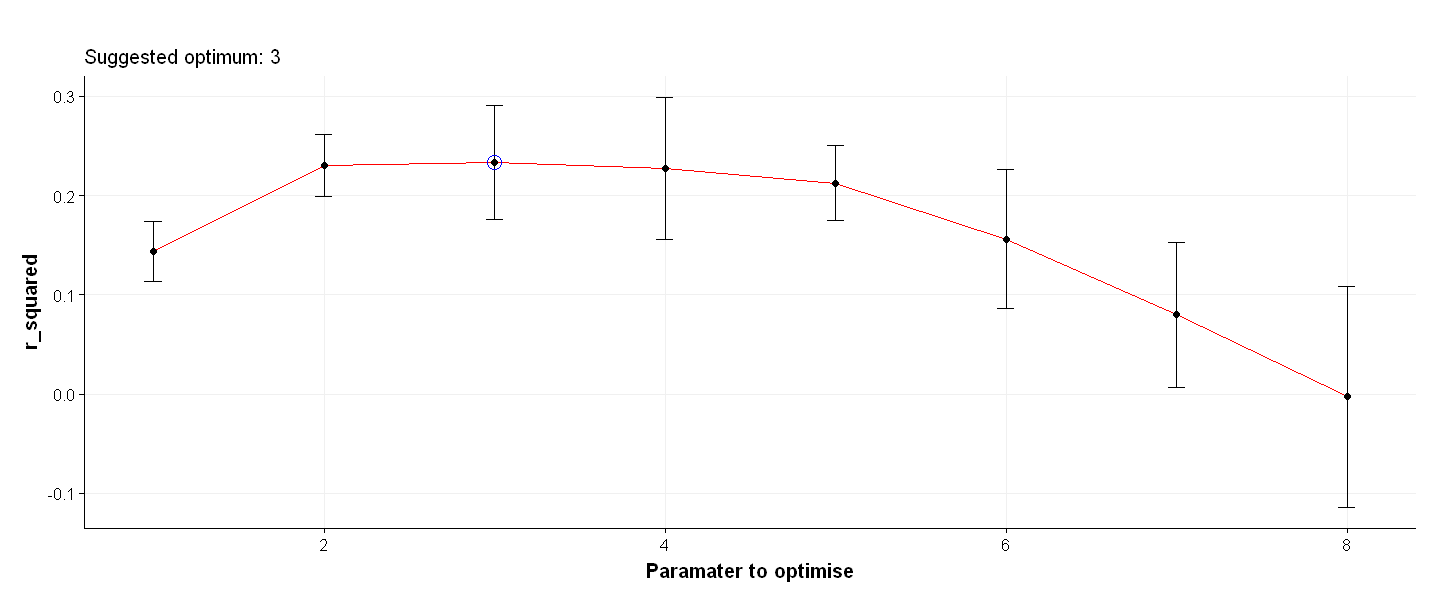

In [22]:
# Convertir outcome a numérico para PLSR
train_prepared$sample_meta$outcome_num <- as.numeric(train_prepared$sample_meta$outcome)

# Optimización con validación cruzada
MS_opt <- grid_search_1d(
  param_to_optimise = 'number_components',
  search_values = 1:8,
  model_index = 2,
  factor_name = 'outcome_num',
  max_min = 'max') *
  permute_sample_order(number_of_permutations = 10) *
  kfold_xval(folds = 5, factor_name = 'outcome_num') * 
  (mean_centre(mode = 'sample_meta') + 
     PLSR(factor_name = 'outcome_num'))

# Ejecutar optimización
MS_opt <- struct::run(MS_opt, train_prepared, r_squared())

# Gráfico de optimización
options(repr.plot.width = 12, repr.plot.height = 5)
C_opt <- gs_line()
chart_plot(C_opt, MS_opt)

# PASO 7: MODELO PLS-DA FINAL
# Seleccionar número óptimo de componentes (ej: 2)
optimal_components <- 2

P <- PLSDA(number_components = optimal_components, factor_name = 'outcome')
P <- model_apply(P, train_prepared)

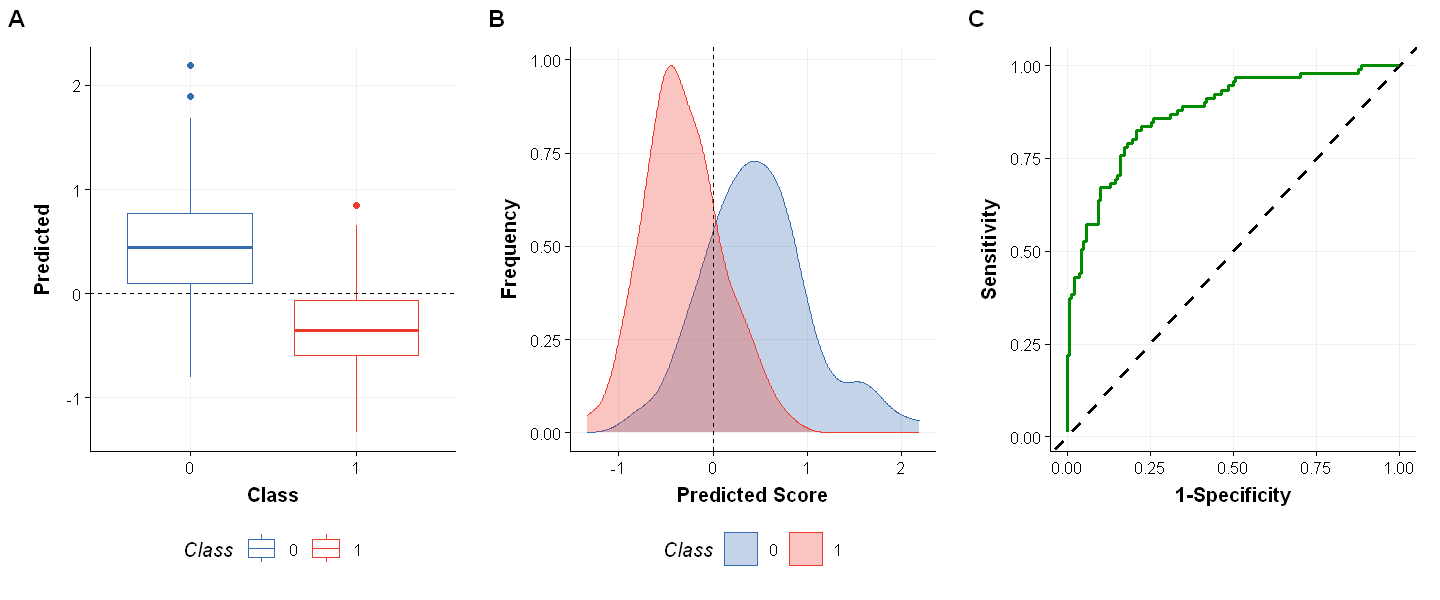

In [23]:
# Gráficos del modelo
options(repr.plot.width = 12, repr.plot.height = 5)
C_pred1 <- plsda_predicted_plot(factor_name = 'outcome', style = 'boxplot')
g_pred1 <- chart_plot(C_pred1, P)

C_pred2 <- plsda_predicted_plot(factor_name = 'outcome', style = 'density')
g_pred2 <- chart_plot(C_pred2, P)

C_roc <- plsda_roc_plot(factor_name = 'outcome')
g_roc <- chart_plot(C_roc, P)

plot_grid(g_pred1, g_pred2, g_roc, align = 'vh', axis = 'tblr', 
          nrow = 1, labels = c('A', 'B', 'C'))

In [18]:
# Calcular AUC
AUC_metric <- calculate(AUC(), P$y$outcome, P$yhat[,1])

print("Estructura del objeto AUC:")
print(str(AUC_metric))
print("Slots disponibles:")
print(slotNames(AUC_metric))

[1] "Estructura del objeto AUC:"
Formal class 'AUC' [package "structToolbox"] with 9 slots
  ..@ type       : chr "classification"
  ..@ value      : num 0.874
  ..@ name       : chr "Area under ROC curve"
  ..@ description: chr "The area under the ROC curve of a classifier is estimated using the trapezoid method."
  ..@ libraries  : chr(0) 
  ..@ citations  :List of 1
  .. ..$ :List of 1
  .. .. ..$ :Classes 'citation', 'bibentry'  hidden list of 1
  .. .. .. ..$ :List of 8
  .. .. .. .. ..$ title  : chr "struct: an R/Bioconductor-based framework for standardized metabolomics data analysis and beyond"
  .. .. .. .. ..$ author :List of 3
  .. .. .. .. .. ..$ :Class 'person'  hidden list of 1
  .. .. .. .. .. .. ..$ :List of 5
  .. .. .. .. .. .. .. ..$ given  : chr [1:2] "Gavin" "Rhys"
  .. .. .. .. .. .. .. ..$ family : chr "Lloyd"
  .. .. .. .. .. .. .. ..$ role   : NULL
  .. .. .. .. .. .. .. ..$ email  : NULL
  .. .. .. .. .. .. .. ..$ comment: NULL
  .. .. .. .. .. ..$ :Class 'per

In [19]:
# Intentar diferentes formas de acceder al valor AUC
auc_value <- NULL
try({
  # Método 1: acceso directo
  if("value" %in% slotNames(AUC_metric)) {
    auc_value <- AUC_metric@value
  }
}, silent = TRUE)

# ... más código de exploración ...

if(!is.null(auc_value)) {
  print(paste("AUC del modelo:", round(auc_value, 3)))
} else {
  print("No se pudo extraer el valor AUC automáticamente")
}

# PASO 8: VALIDACIÓN POR PERMUTACIÓN
MS_perm <- permutation_test(number_of_permutations = 50, factor_name = 'outcome_num') * 
  kfold_xval(folds = 5, factor_name = 'outcome_num') *
  (mean_centre(mode = 'sample_meta') + 
     PLSR(factor_name = 'outcome_num', number_components = optimal_components))

MS_perm <- struct::run(MS_perm, train_prepared, r_squared())


[1] "AUC del modelo: 0.874"


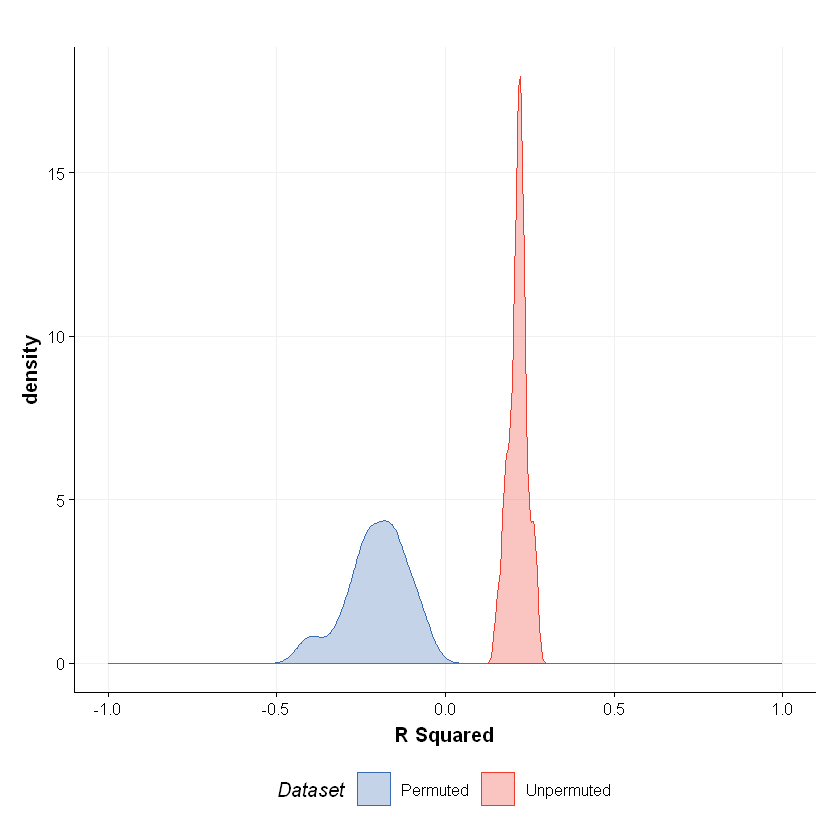

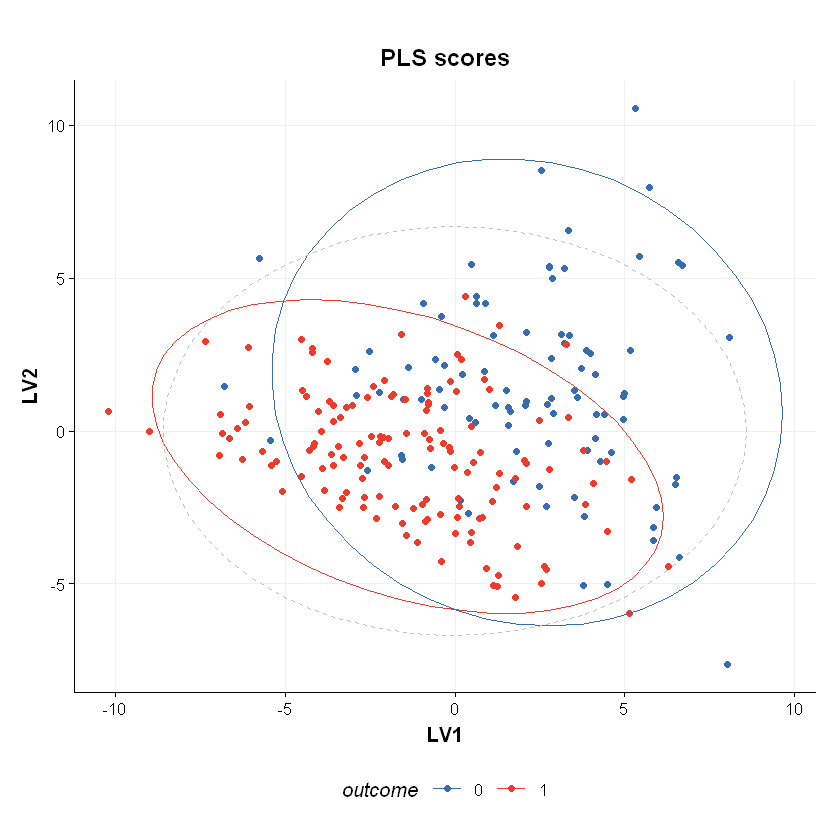

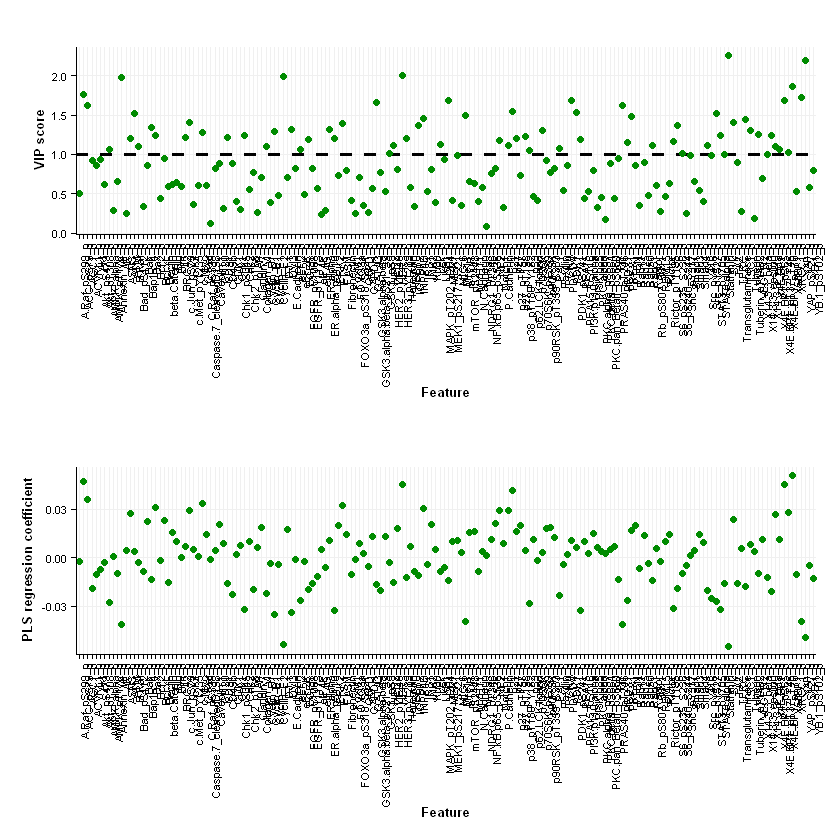

In [20]:
# Gráfico de permutación
C_perm <- permutation_test_plot(style = 'density')
chart_plot(C_perm, MS_perm) + xlim(c(-1, 1)) + xlab('R Squared')

# PASO 9: IDENTIFICACIÓN DE PROTEÍNAS IMPORTANTES
# Scores plot
C_scores <- pls_scores_plot(components = c(1, 2), factor_name = 'outcome')
chart_plot(C_scores, P)

# VIP scores - Proteínas más importantes
C_vip <- pls_vip_plot(ycol = levels(P$y$outcome)[1])  # Primera clase
g_vip <- chart_plot(C_vip, P)

# Coeficientes de regresión
C_coeff <- pls_regcoeff_plot(ycol = levels(P$y$outcome)[1])
g_coeff <- chart_plot(C_coeff, P)

plot_grid(g_vip, g_coeff, align = 'hv', axis = 'tblr', nrow = 2)


In [21]:
# Extraer las proteínas más importantes (VIP > 1.0)
vip_scores <- P$vip
important_proteins <- rownames(vip_scores)[vip_scores[,1] > 1.0]

print("Proteínas más importantes (VIP > 1.0):")
print(important_proteins)


[1] "Proteínas más importantes (VIP > 1.0):"
 [1] "X14.3.3_epsilon_p"  "X14.3.3_zeta_p"     "X4E.BP1_p"         
 [4] "X4E.BP1_pS65_p"     "X4E.BP1_pT37_T46_p" "X4E.BP1_pT70_p"    
 [7] "X53BP1_p"           "ACC1_p"             "ACC_pS79_p"        
[10] "AMPK_alpha_p"       "AR_p"               "ATM_p"             
[13] "B.Raf_p"            "Bad_pS112_p"        "Bax_p"             
[16] "Bcl.2_p"            "C.Raf_p"            "CD49b_p"           
[19] "Chk2_p"             "Cyclin_B1_p"        "Cyclin_E1_p"       
[22] "DJ.1_p"             "E.Cadherin_p"       "EGFR_pY1068_p"     
[25] "ER.alpha_pS118_p"   "ERK2_p"             "FASN_p"            
[28] "GSK3.alpha.beta_p"  "HER2_p"             "HER2_pY1248_p"     
[31] "HER3_pY1289_p"      "Heregulin_p"        "INPP4B_p"          
[34] "IRS1_p"             "LKB1_p"             "MEK1_p"            
[37] "Notch1_p"           "PDK1_p"             "PDK1_pS241_p"      
[40] "PEA15_p"            "PRDX1_p"            "PREX1_p"           
[43